In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

import pandas as pd
from sklearn.model_selection import train_test_split

from loguru import logger

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Download COCO-2017 dataset

**Selected classes for multi-class classification:**
 * cat
 * dog
 * horse


In [2]:
fo.list_datasets()

['coco-2017-1000',
 'coco-2017-train-validation-2000',
 'coco-2017-validation-25',
 'my-classification-dataset',
 'my-detection-dataset',
 'my-segmentation-dataset']

In [3]:
dataset = foz.load_zoo_dataset(
    "coco-2017",
    splits=["train", "validation"],
    classes=["cat", "dog", "horse"],
    max_samples=2000,
    only_matching=True,
)


session = fo.launch_app(dataset, auto=False)
session

Found annotations at '/Users/mlstudio/fiftyone/coco-2017/raw/instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Found annotations at '/Users/mlstudio/fiftyone/coco-2017/raw/instances_val2017.json'
Only found 473 (<2000) samples matching your requirements
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-train-validation-2000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require 

Dataset:          coco-2017-train-validation-2000
Media type:       image
Num samples:      2473
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/

In [4]:
sample = dataset.first()

sample

<Sample: {
    'id': '66f97c74ffafd310dd30b634',
    'media_type': 'image',
    'filepath': '/Users/mlstudio/fiftyone/coco-2017/train/data/000000000042.jpg',
    'tags': ['train'],
    'metadata': <ImageMetadata: {
        'size_bytes': None,
        'mime_type': None,
        'width': 640,
        'height': 478,
        'num_channels': None,
    }>,
    'ground_truth': <Detections: {
        'detections': [
            <Detection: {
                'id': '66f97c74ffafd310dd30b633',
                'attributes': {},
                'tags': [],
                'label': 'dog',
                'bounding_box': [0.334609375, 0.0863807531380753, 0.54415625, 0.51],
                'mask': None,
                'confidence': None,
                'index': None,
                'supercategory': 'animal',
                'iscrowd': 0,
            }>,
        ],
    }>,
}>

## Filtering samples for multi-class

*Remove any sample that has more than one label"

In [5]:
list_samples = []

for sample in dataset:
    if sample["ground_truth.detections"] is None:
        continue
    labels = set([det["label"] for det in sample["ground_truth.detections"]])
    tag = sample["tags"][0]
    if len(labels) == 1:
        list_samples.append((sample["filepath"], labels.pop(), tag))

df = pd.DataFrame(list_samples, columns=["filepath", "label", "tag"])
df.head()

,filepath,label,tag
0,/Users/mlstudio/fiftyone/coco-2017/train/data/...,dog,train
1,/Users/mlstudio/fiftyone/coco-2017/train/data/...,horse,train
2,/Users/mlstudio/fiftyone/coco-2017/train/data/...,dog,train
3,/Users/mlstudio/fiftyone/coco-2017/train/data/...,dog,train
4,/Users/mlstudio/fiftyone/coco-2017/train/data/...,dog,train


<Axes: title={'center': 'Number of samples per split'}, xlabel='tag'>

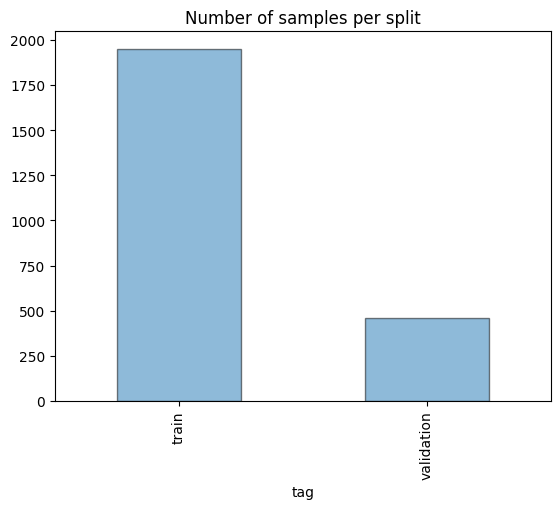

In [6]:
# bar plot of train/test/validation split
df["tag"].value_counts().plot(
    kind="bar", alpha=0.5, edgecolor="black",
    title="Number of samples per split"
)

<Axes: title={'center': 'Label distribution'}, xlabel='label'>

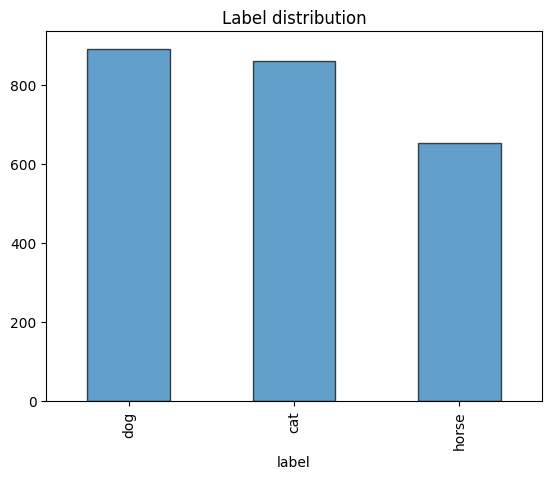

In [7]:
# bar plot of label distribution
df["label"].value_counts().plot(
    kind="bar", alpha=0.7, edgecolor="black",
    title="Label distribution"
)

In [8]:
logger.info(f"Number of samples: {len(df)}")
logger.info(f"Number of unique labels: {len(df['label'].unique())}")
logger.info(f"Number of Train samples: {len(df[df['tag'] == 'train'])}")
logger.info(f"Number of Validation samples: {len(df[df['tag'] == 'validation'])}")


2024-09-29 11:15:32.991 | INFO     | __main__:<module>:1 - Number of samples: 2406
2024-09-29 11:15:32.992 | INFO     | __main__:<module>:2 - Number of unique labels: 3
2024-09-29 11:15:32.994 | INFO     | __main__:<module>:3 - Number of Train samples: 1949
2024-09-29 11:15:32.995 | INFO     | __main__:<module>:4 - Number of Validation samples: 457


In [9]:
# use current validation set as test set
df_test = df[df["tag"] == "validation"].reset_index(drop=True)
df_test["tag"] = "test"

# split train -> train/val (80%/20%)
df_train = df[df["tag"] == "train"].reset_index(drop=True)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)
df_train["tag"] = "train"
df_val["tag"] = "val"

# concatenate
df = pd.concat([df_train, df_val, df_test]).reset_index(drop=True)

df.to_csv("data.csv", index=False)

In [10]:
dataset.delete()

In [13]:
logger.info(f"Number of samples: {len(df)}")
logger.info(f"Number of unique labels: {len(df['label'].unique())}")
logger.info(f"Number of Train samples: {len(df[df['tag'] == 'train'])}")
logger.info(f"Number of Validation samples: {len(df[df['tag'] == 'val'])}")
logger.info(f"Number of Test samples: {len(df[df['tag'] == 'test'])}")


2024-09-29 11:17:10.485 | INFO     | __main__:<module>:1 - Number of samples: 2406
2024-09-29 11:17:10.487 | INFO     | __main__:<module>:2 - Number of unique labels: 3
2024-09-29 11:17:10.489 | INFO     | __main__:<module>:3 - Number of Train samples: 1559
2024-09-29 11:17:10.491 | INFO     | __main__:<module>:4 - Number of Validation samples: 390
2024-09-29 11:17:10.492 | INFO     | __main__:<module>:5 - Number of Test samples: 457
